In [40]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.


par = model.par
sol = model.sol
sim = model.sim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
df = pd.read_csv('Data/formue_cohort.csv')
df = df[(df['KOEN']==1) & (df['ALDER']<100)]
file_path = 'Data/salary_hours.xlsx'
data = pd.read_excel(file_path)

# grund data
s_data = np.array(df['FGCX'])
a_data = np.array(df['nettoform_u_pf'])
h_data = np.array(data["gender"].iloc[2:]) / 1924

# Compute means for each type of data
s_mean = np.mean(s_data)
a_mean = np.mean(a_data)
h_mean = np.mean(h_data[:35])  # Since we're truncating h_data

# Normalize data moments
s_data_scaled = s_data / s_mean
a_data_scaled = a_data / a_mean
h_data_scaled = h_data[:35] / h_mean  # Only the first 35

# Concatenate into final scaled data moments
mom_data = np.concatenate((s_data_scaled, a_data_scaled, h_data_scaled))

In [42]:
def moment_func(sim_data):
    # Compute age-averaged moments
    avg_s_by_age = np.mean(sim_data.s, axis=0)  # Length 70
    avg_a_by_age = np.mean(sim_data.a, axis=0)  # Length 70
    avg_h_by_age = np.mean(sim_data.h, axis=0)  # Length 70

    # Truncate h to first 35
    avg_h_by_age_trunc = avg_h_by_age[:35]

    # Scale moments (same as data scaling)
    avg_s_scaled = avg_s_by_age / s_mean
    avg_a_scaled = avg_a_by_age / a_mean
    avg_h_scaled = avg_h_by_age_trunc / h_mean

    # Concatenate and return
    return np.concatenate((avg_s_scaled, avg_a_scaled, avg_h_scaled))


def simulate_moments(theta, theta_names, model):
        
    # 1. Update model parameters
    for i, name in enumerate(theta_names):
        setattr(model.par, name, theta[i])
    
    # 2. Solve and simulate the model
    model.solve()
    model.simulate()
    
    # 3. Return the expanded vector of simulated moments
    return moment_func(model.sim)

def obj_func(theta, theta_names, mom_data, model, do_print=False):
    start_time = time.time()  # Start timing

    if do_print: 
        print_str = ''
        for i, name in enumerate(theta_names):
            print_str += f'{name}={theta[i]:2.3f} '
        print(print_str)
    
    # Compute simulated moments
    mom_sim = simulate_moments(theta, theta_names, model)
   
    # Sum of squared errors over all 175 elements
    obj = np.sum((mom_data - mom_sim)**2)

    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time
    
    if do_print: 
        print(f"Error = {obj:.6f}, Time = {elapsed_time:.4f} seconds")

    return obj

In [45]:
theta_names = ("beta", "sigma", "gamma", "mu", "r_s", "r_a")

objective = lambda theta: obj_func(theta, theta_names, mom_data, model, do_print=True)

theta_init = np.array([0.976, 1.026, 4.723, 7.887, 0.015, 0.009])

# res = minimize(
#     objective, 
#     theta_init,
#     method='Nelder-Mead',
#     bounds=[(0.0, 1.0), (0.1, 6.0), (0.1, 6.0), (0.0, 5.0), (0.0, 0.1), (0.0, 0.1)],
#     tol=1e-6,
#     options={"maxiter":10000}
# )

from scipy.optimize import differential_evolution

# # Step 1: Global Search with Differential Evolution
# res_global = differential_evolution(
#     objective, 
#     bounds=[(0.0, 1.0), (0.1, 6.0), (0.1, 6.0), (0.0, 5.0), (0.0, 0.1), (0.0, 0.1)],
#     strategy='best1bin', 
#     tol=1e-6,
#     maxiter=000,
#     disp=True
# )
# print('Now, L-BFGS-B')
# # Step 2: Use Global Solution for Local Refinement
# res = minimize(
#     objective, 
#     res_global.x,  # Use best result from global optimizer
#     method='L-BFGS-B',
#     bounds=[(0.0, 1.0), (0.1, 6.0), (0.1, 6.0), (0.0, 5.0), (0.0, 0.1), (0.0, 0.1)],
#     tol=1e-6,
#     options={"maxiter": 10000}
# )

res = minimize(
    objective, 
    theta_init,
    method='Nelder-Mead',
    bounds=[(0.0, 1.0), (0.1, 6.0), (0.1, 10.0), (0.0, 10.0), (0.0, 0.02), (0.0, 0.1)],
    tol=1e-6,
    options={"maxiter":10000, "adaptive": True}
)

print(res)


beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 4.328260, Time = 2.7417 seconds
beta=1.000 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 272.000620, Time = 2.7367 seconds
beta=0.976 sigma=1.077 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 7.530342, Time = 2.7969 seconds
beta=0.976 sigma=1.026 gamma=4.959 mu=7.887 r_s=0.015 r_a=0.009 
Error = 4.335018, Time = 2.8989 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=8.281 r_s=0.015 r_a=0.009 
Error = 4.633393, Time = 2.8853 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.016 r_a=0.009 
Error = 4.328437, Time = 2.9549 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 4.379084, Time = 3.0987 seconds
beta=0.952 sigma=1.043 gamma=4.802 mu=8.018 r_s=0.015 r_a=0.009 
Error = 16.505434, Time = 3.1239 seconds
beta=0.960 sigma=1.040 gamma=4.789 mu=7.997 r_s=0.015 r_a=0.009 
Error = 11.746236, Time = 3.3601 seconds
beta=0.992 sigma=1.029 gamma=4.736 mu=7.909 r_s=0.0

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numba/core/serialize.py", line 30, in _numba_unpickle
    def _numba_unpickle(address, bytedata, hashed):
KeyboardInterrupt

The above exception was the direct cause of the following exception:

SystemError: _PyEval_EvalFrameDefault returned a result with an exception set

The above exception was the direct cause of the following exception:

SystemError: _PyEval_EvalFrameDefault returned a result with an exception set

The above exception was the direct cause of the following exception:

SystemError: _PyEval_EvalFrameDefault returned a result with an exception set

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/mathiasberg/Design_retirement/model.py", line 173, in solve
    sol.c[:, :, :, :], sol.a[:, :, :, :], sol.h[:, :, :, :], sol.V[:, :, :, :] = main_solver_loop(par, sol, do_print)
SystemE

SystemError: CPUDispatcher(<function main_solver_loop at 0x141e60550>) returned a result with an exception set

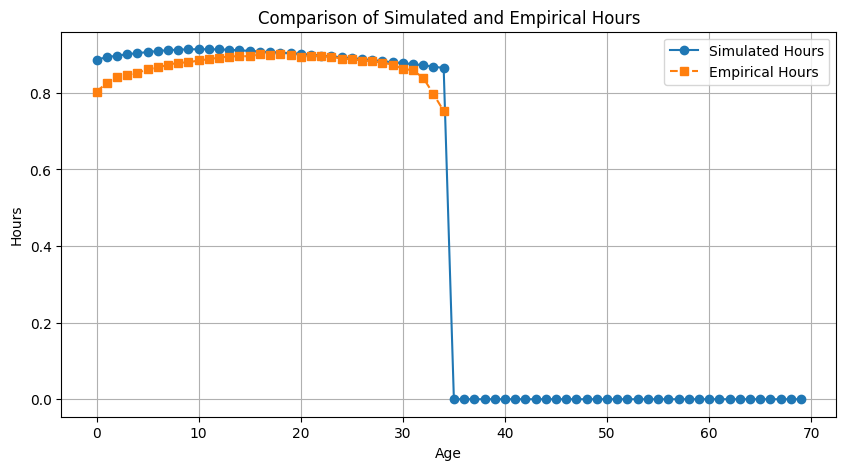

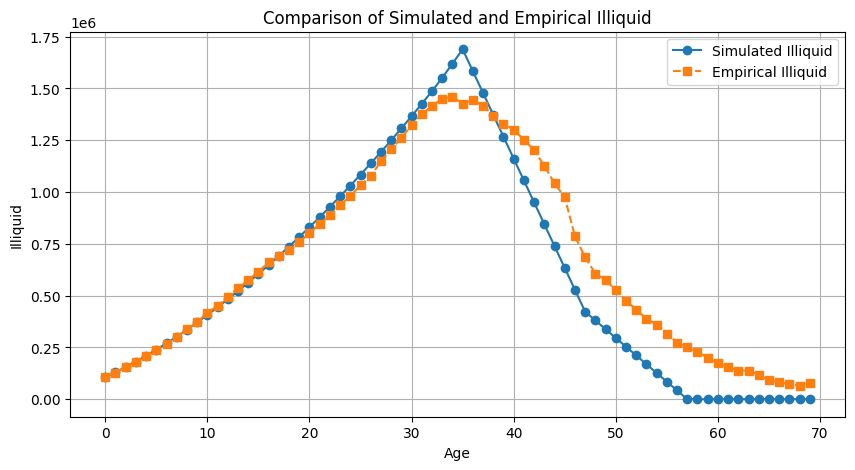

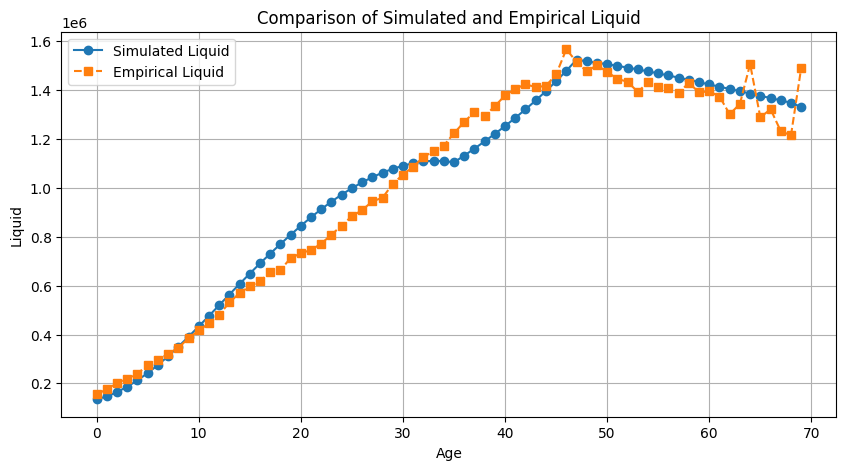

In [46]:
theta_names = ("beta", "sigma", "gamma", "mu", "r_s", "r_a")
theta_init = np.array([0.982, 1.060, 3.877, 7.814, 0.02, 0.009])

for i, name in enumerate(theta_names):
    setattr(model.par, name, theta_init[i])
model.solve()
model.simulate()
a_dict = {
    'hours': [np.mean(model.sim.h, axis=0), h_data],
    'illiquid': [np.mean(model.sim.s, axis=0), s_data],
    'liquid': [np.mean(model.sim.a, axis=0), a_data]  # Example of future expansion
}

# Plot each key dynamically
for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    plt.plot(simulated, label=f"Simulated {key.capitalize()}", marker="o")
    plt.plot(empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s")
    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
a_dict = {
    'hours': [np.mean(model.sim.h, axis=0), h_data],
    'illiquid': [np.mean(model.sim.s, axis=0), s_data],
    'liquid': [np.mean(model.sim.a, axis=0), a_data]  # Example of future expansion
}

# Plot each key dynamically
for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    plt.plot(simulated, label=f"Simulated {key.capitalize()}", marker="o")
    plt.plot(empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s")
    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
df = pd.read_csv('Data/formue_cohort.csv')
df = df[(df['KOEN']==1) & (df['ALDER']<100)]
file_path = 'Data/salary_hours.xlsx'
data = pd.read_excel(file_path)

s_data = np.array(df['FGCX'])
a_data = np.array(df['nettoform_u_pf'])
h_data = np.array(data["gender"].iloc[2:]) / 1924
h_data_trunc = h_data[:35]
mom_data = np.concatenate((s_data, a_data, h_data_trunc))


In [36]:
def obj_func(theta,theta_names,mom_data,model,do_print=False):
    
    # printing
    if do_print: 
        print_str = ''
        for i,name in enumerate(theta_names):
            print_str += f'{name}={theta[i]:2.3f} '
        print(print_str)
            
    # calculate moments from simulation
    mom_sim = simulate_moments(theta,theta_names,model)
   
    # equal weighting
    obj = np.sum((mom_data - mom_sim[:35])**2)
    if do_print: 
        print("error", obj)
    
    # return objective and moments for plotting
    return obj

def simulate_moments(theta,theta_names,model):
        
    # update parameters
    for i,name in enumerate(theta_names):
        setattr(model.par,name,theta[i])
    
    # solve and simulate model with these parameters
    model.solve()
    model.simulate()
    
    # return moments from simulated data
    return moment_func(model.sim)

def moment_func(input_data):
    return np.mean(input_data.h,axis=0) # age profile of wealth


In [ ]:
def moment_func(sim_data):
    # sim_data.s, sim_data.a, sim_data.h each shape (N, 70)
    
    # 1. Average by age across individuals
    avg_s_by_age = np.mean(sim_data.s, axis=0)  # -> length 70
    avg_a_by_age = np.mean(sim_data.a, axis=0)  # -> length 70
    avg_h_by_age = np.mean(sim_data.h, axis=0)  # -> length 70
    
    # 2. Concatenate into one vector of length 210
    return np.concatenate((avg_s_by_age, avg_a_by_age, avg_h_by_age))

def simulate_moments(theta, theta_names, model):
        
    # 1. Update model parameters
    for i, name in enumerate(theta_names):
        setattr(model.par, name, theta[i])
    
    # 2. Solve and simulate the model
    model.solve()
    model.simulate()
    
    # 3. Return the expanded vector of simulated moments
    return moment_func(model.sim)


In [37]:
theta_names = ("beta", "sigma", "gamma", "mu")
# call numerical optimizer
objective = lambda theta: obj_func(theta,theta_names,h_data,model,do_print=True)

theta_init = np.array([par.beta,par.sigma, par.gamma, par.mu]) 

res = minimize(objective,theta_init,method='trust-constr',bounds=[(0.0, 1.0), (0.1, 6.0), (0.1, 6.0), (0.0, 5.0)], tol=1e-6, options= {"maxiter":10000})
res

In [ ]:
# call numerical optimizer
objective = lambda theta: obj_func(theta,theta_names,h_data,model,do_print=True)

theta_init = np.array([par.beta,par.sigma, par.gamma, par.mu]) 

res = minimize(objective,theta_init,method='trust-constr',bounds=[(0.0, 1.0), (0.1, 6.0), (0.1, 6.0), (0.0, 5.0)], tol=1e-6, options= {"maxiter":10000})
res

In [39]:
mom_sim = simulate_moments(res.x,theta_names,model)

In [ ]:
plt.plot(h_data)
plt.plot(mom_sim[:35])